## 明确问题

1. 机器模型用于解决**业务问题**
- pipeleine: 上游组件 -> 街区数据 -> **街区价格估计** -> 提供街区估值（作为下游输入） -> 投资分析 -> 某个街区是否值得投资
- 每个组件/模块各自独立，异步进行；数据仓库的模式，分团队开发，鲁棒性，某个组件挂掉不会影响其他

2. 如何解决问题？
- **监督学习**：数据有标注
- **回归**：房价连续值；多元回归，多维X
- **批量学习**：不是在线学习，没有持续的数据流，没有对快速变化及时响应的需求，数据集不大可以全部加载到内存；若数据集很大->分布式框架 MapReduce
- 批量学习（batch learning），一次性批量输入给学习算法，可以被形象的称为填鸭式学习。
- 在线学习（online learning），按照顺序，循序的学习，不断的去修正模型，进行优化。

3. **衡量指标**
- **均方根误差RMSE = sqrt(sum((fx-y)^2)/n)：L2范数，欧几里得距离**
- **平方均误差MAE = sum(|fx - y|)/n： 对异常值没有那么敏感，由于没有用平方；L1范数，曼哈顿距离**（横轴+纵轴而非L2斜线）
- 范数阶级越高，越关心值比较大的数据，对极端值更敏感

4. **检验假设是否正确**
- 如果下游的输入是枚举类型（便宜/中等/贵)，分类问题，而不是回归

In [2]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt

## 构建数据集；如果需要自己分train test set
### 随机抽样

In [28]:
def split_train_test(data, test_ratio):
    #np.random.seed(1)
    shuffled_indices = np.random.permutation(len(data)) # 问题random 每次随机出的test dataset不一致
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

from sklearn.model_selection import train_test_split 
#housing_with_id = 精度+维度
#train, test = train_test_split(housing, test_size = 0.2, random_state = 42)

### 分层抽象

对于重要特征，希望测试集的数据能够有足够代表性的样本覆盖；不同层次都应该有所覆盖

In [36]:
#比如 LotFrontage 
#首先 离散化 -> 枚举型
house['LotFrontage_cat'] = np.ceil(house['LotFrontage']/1.5)
house['LotFrontage_cat'].where(house['LotFrontage']<100, 100.0, inplcce = True)

#分层抽样
from sklearn.model_selection import StratifiedShuffleSPlit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)#创建一个split类
for train_index, test_index in split.split(house, house['LotFrontage_cat']):
    train_data = house.iloc[train_index] 
    test_data = house.iloc[test_index]
    
#删除用于抽样的信息列
for s in (strat_train_set, strat_test_set):
    s.drop(['LotFrontage_cat'], axis=1, inplace= True)

NameError: name 'np' is not defined

## 加载数据

In [3]:
HOUSE_PATH = './data'
def load_house_data(house_train_path = HOUSE_PATH):
    csv_path = os.path.join(house_train_path,'train.csv')
    return pd.read_csv(csv_path)

In [4]:
train_data = load_house_data()
test_data = pd.read_csv('./data/test.csv') #不应该分析test dataset；否则过拟合测试集
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 观察数据

- 发现**大量缺失值**的特征：Alley/ FireplaceQu/  PoolQC/ Fence / MiscFeatur
- data type : int float object / quanti qualli

In [9]:
train_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [29]:
train_data['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [28]:
train_data.groupby('MSZoning')['SalePrice'].mean()

MSZoning
C (all)     74528.000000
FV         214014.061538
RH         131558.375000
RL         191004.994787
RM         126316.830275
Name: SalePrice, dtype: float64

In [25]:
train_data['SaleCondition'].mode()

0    Normal
dtype: object

In [19]:
quantitative = [i for i in train_data.columns if train_data.dtypes[i] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [i for i in train_data.columns if train_data.dtypes[i] == 'object']
print("In all ", train_data.shape[1]," features, we have ", len(quantitative)," quantitative numbers features, wheras ", len(qualitative)," qualitative objet features")

In all  81  features, we have  36  quantitative numbers features, wheras  43  qualitative objet features


## 观察Quantitative属性的大致分布：
- 均值 
- 标准差
- 偏度：LotAres MAX与75%相差大，头重脚轻的长尾分布？ -> Outlier? -> 尽量转换成正态分布

In [13]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [44]:
train_data['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

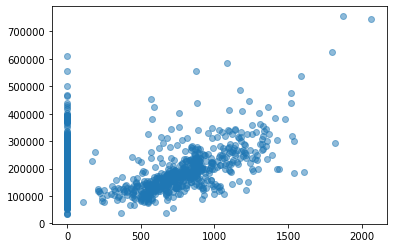

In [33]:
#plt.scatter(train_data['Id'],train_data['LotFrontage'])
plt.scatter(train_data['2ndFlrSF'],train_data['SalePrice'],alpha=0.5)

In [34]:
print(train_data[train_data['2ndFlrSF']>2000].Id)

1182    1183
Name: Id, dtype: int64


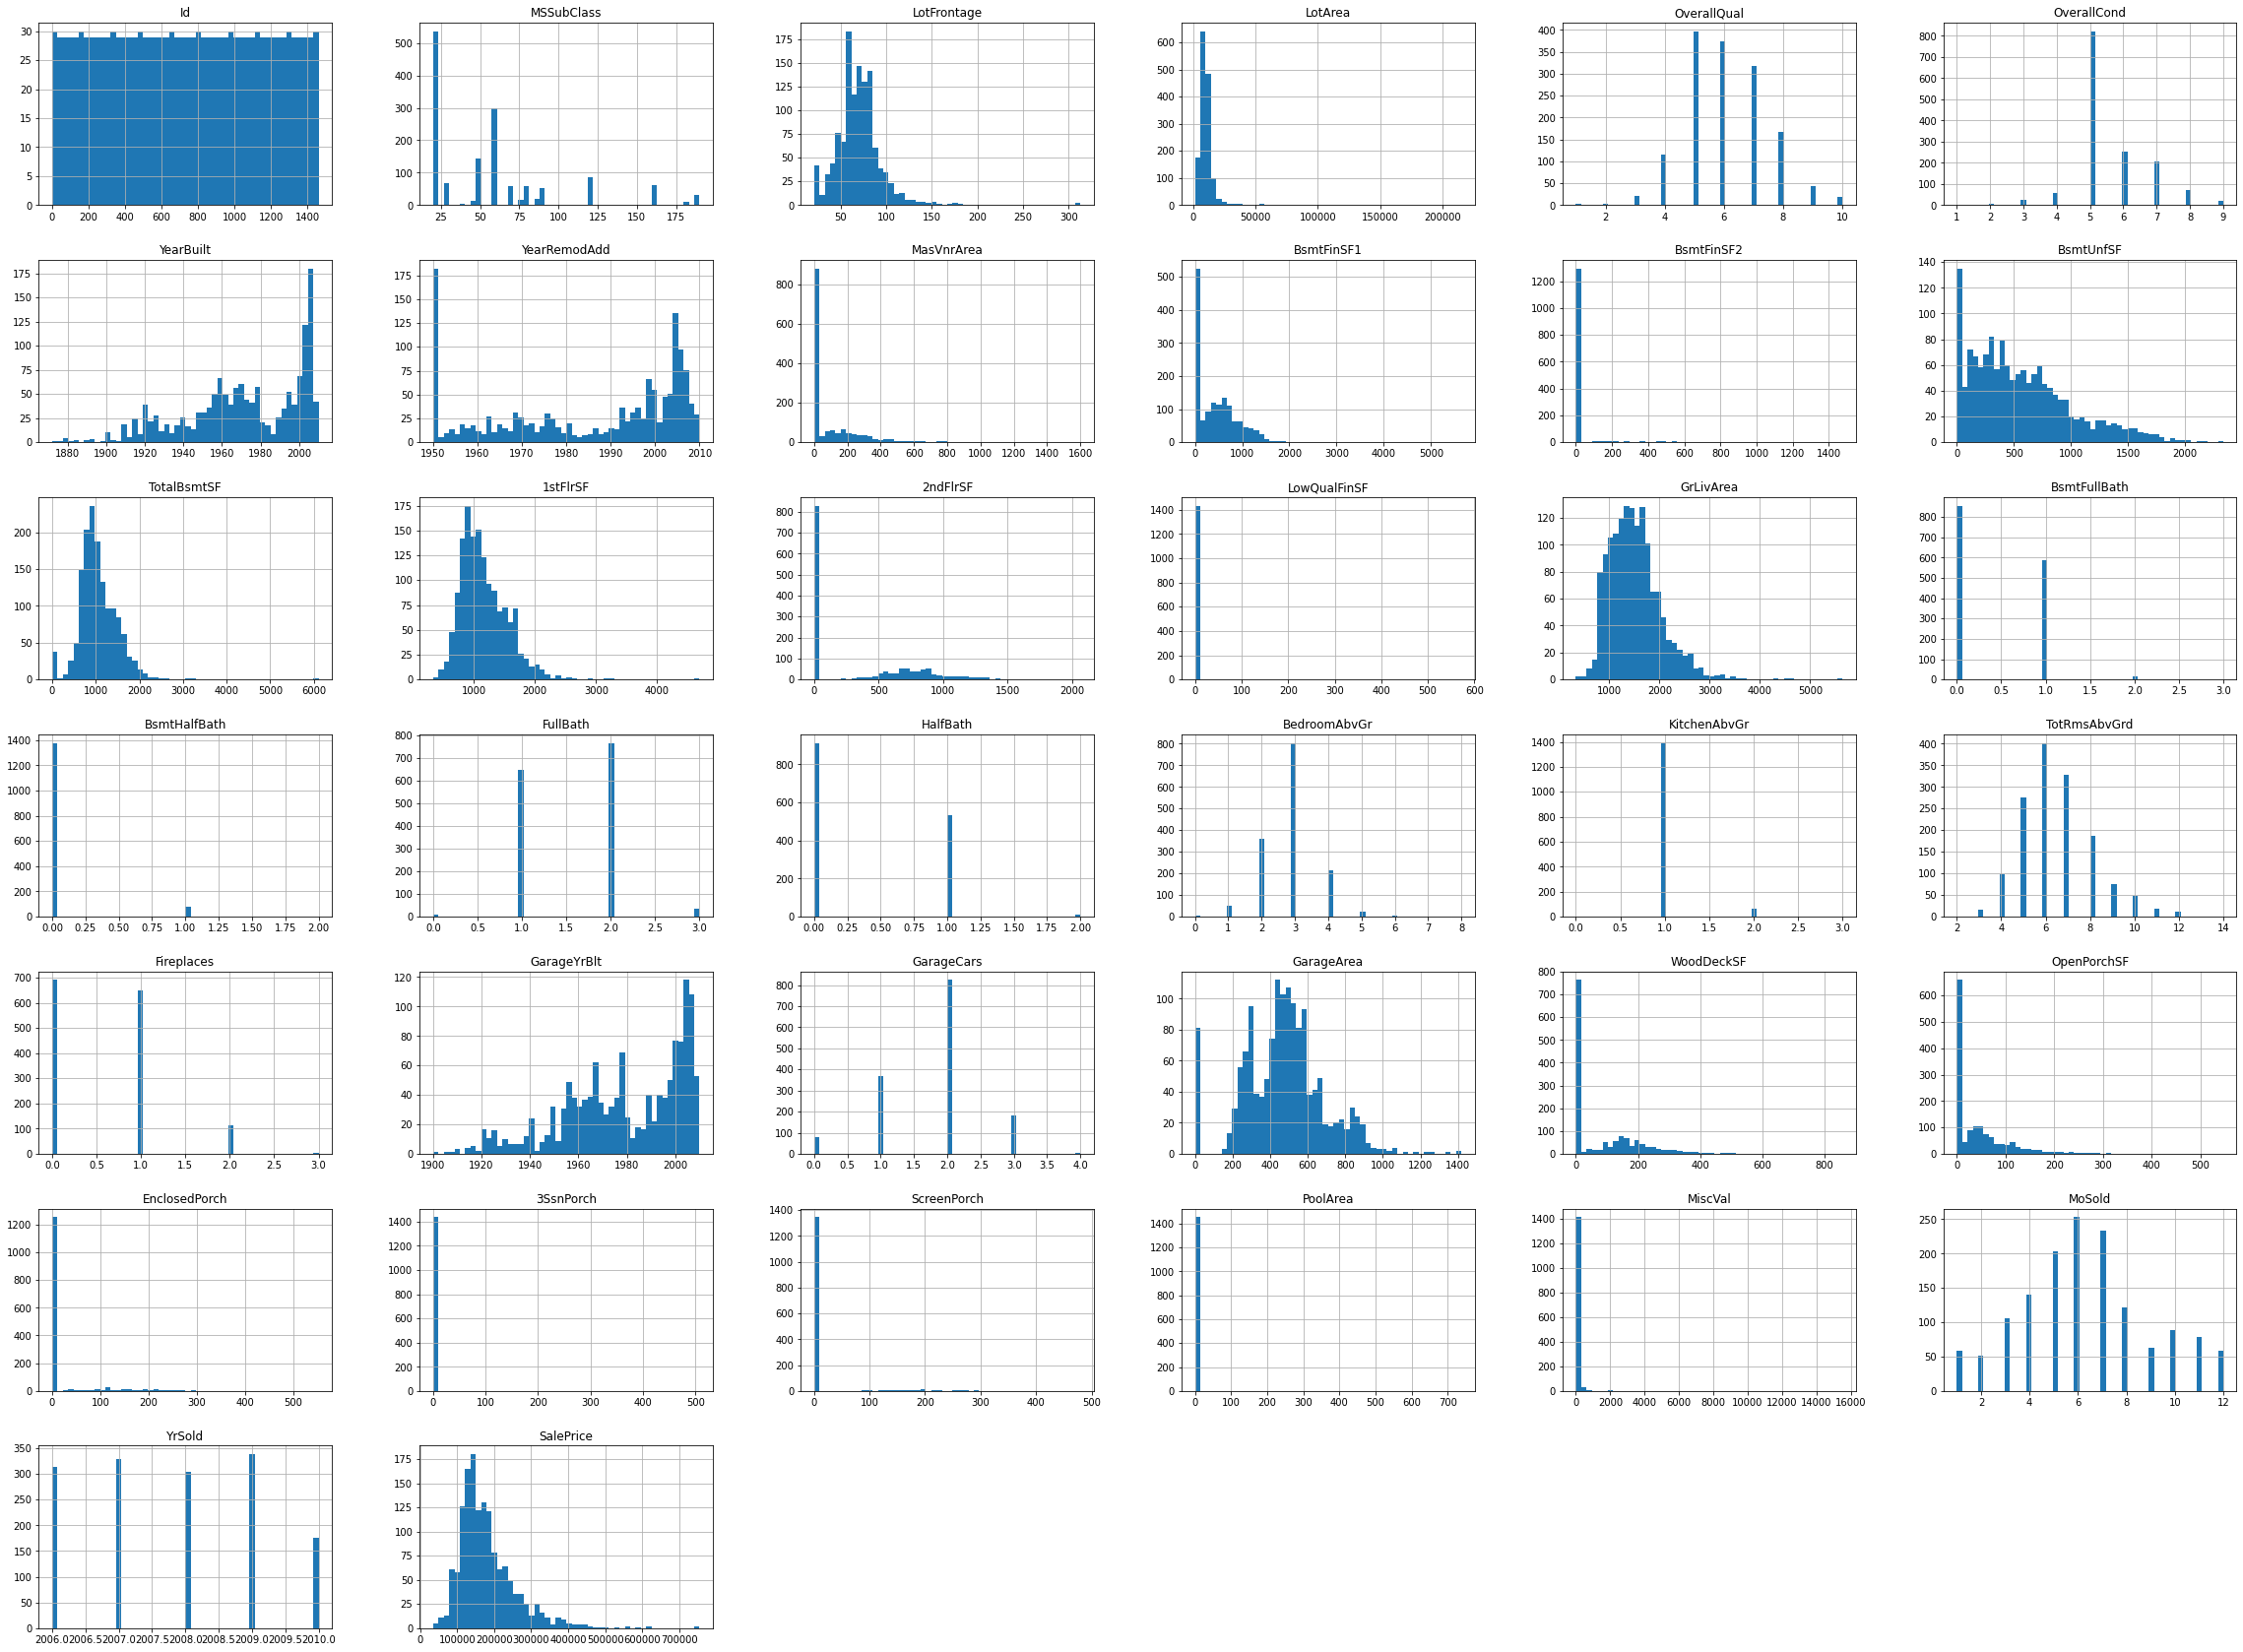

In [27]:
train_data.hist(bins=50, figsize=(40,30))
plt.show()

## peason相关性

两个变量之间的皮尔逊相关系数定义为两个变量的协方差除以它们标准差的乘积

In [35]:
corr_matrix = train_data.corr() #数值特性之间的相关性； 只能捕获到 线性相关

print(corr_matrix['SalePrice'].sort_values(ascending=False))

from pandas.plotting import scatter_matrix #对角线 特征分布hist；其余为相关性 观察线性相关

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

## 试试特征组合

如房价和面积，生成新的attribute 每平方米的价格

然后再观察其相关性，以判断新特征是否比较好

## 数据清洗

对于quantitative特征的缺失值：
- data.dropna(subset= ['col name'])
- data.drop("col_name", axis = 1)
- data(["col_name"].fillna(median); median = data["col_name"].median()

In [ ]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')  #mean #most_frequence
imputer.fit(quantitative_data)
imputer.statistics

tmp = imputer.transform(quantitative_data) #np.ndarry
#转换成data frame
house_tr = pd.DataFrame(tmp, columns = quantitative_data.columns)#表头

## 处理文本数据和类别属性

转换成数值特征
- 编码成1、2、3...；但是对于机器学习，数值的相对大小是有影响的，对于枚举的类别特征，不应该存在大小的关系
- one-hot encode

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
tmp = encoder.fit_transform(qualitative_data)
encoder.classes_

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
quali_encoded = encoder.fit_transform(tmp.reshape(-1,1)) #oneHotEncoder 只能接受数值型的数值
quali_encoded_toarray()

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarier #上述二合一
tmp = encoder.fit_transform(qualitative_data， spare_output = True) #稀疏矩阵，减少内存

## 自定义转换器

实现fit\transform函数； 无需继承

鸭子类型（英语：duck typing）是动态类型的一种风格。在这种风格中，一个对象有效的语义，不是由继承自特定的类或实现特定的接口，而是由"当前方法和属性的集合"决定。

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

room_ix, popultion_ix, household_ix = 1,2,3

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, choice = True):
        self.choice = choice
        
    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y = None):
        rooms_per_household = X[:,room_ix]/X[:,household_ix]
        if self.choice = True:
            population_per_household = X[:,population_ix]/X[:,household_ix]
            return np.c_[X, room_per_household, population_per_household]
        else:
            return np.c_[X, room_per_household]
        
#np.r_是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等。
#np.c_是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等。

attr_adder = CombinedAttributesAdder(choice=True)
tmp = attr_adder.fit(house_data.value)

SyntaxError: unexpected EOF while parsing (<ipython-input-37-a3c326fbba00>, line 13)

## Transformation pipeline

In [ ]:
from sklearn.pipeling import FeatureUnion

number_attributes = list(house_number)

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(number_attributes)),
    ('imputer', Imputerr(strategy='median')),
    ('std_scaler', StandarScaler())
])
#tmp = num_pipeline.fit_transform()

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attributes)),
    ('label_binarizer',LabelBinarizer())
]) #串行

full_pipeline = FeatureUnion(transformer_list = [
    ('number_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline)
]) #并行